In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
import pandas as pd

In [53]:
df = pd.read_csv('data/gradients.csv')

In [54]:
df.head()

,subject,epoch,region,7net,17net,g1,g2,g3,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,1.598490
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,1.827782
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,1.954351
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,3.142568
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,1.268644


# ttests
compare `ecc` values between epochs. False discovery rate (FDR) correction applied.

In [55]:
import pingouin as pg

In [56]:
from matplotlib import pyplot as plt

In [57]:
dfpair = df.groupby(['region', '7net', '17net']).apply(
    pg.pairwise_tests, dv='ecc', subject='subject', padjust='fdr_bh',
    within='epoch'  # within instead of between, makes it paired
    )

In [58]:
# longer name for variable with big computation

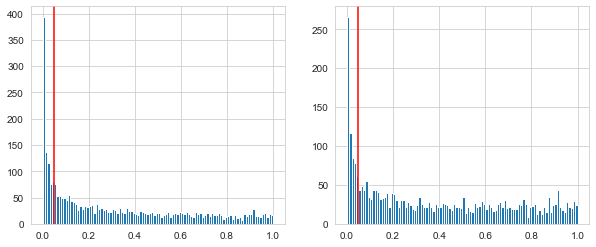

In [59]:
# fdr corrected on right panel
_, ax = plt.subplots(ncols=2, figsize=(10,4))
dfpair['p-unc'].hist(bins=100, ax=ax[0]) # uncorrected p value
ax[0].axvline(x=.05, color='red') # type-I error
dfpair['p-corr'].hist(bins=100, ax=ax[1]) # corrected p value
ax[1].axvline(x=.05, color='red') # type-I error
plt.show()

In [60]:
region_names = pd.read_csv('data/regions_sorted.csv')['region']

In [61]:
# epoch pairs set to be index
dfp = dfpair.reset_index(3)
dfp = dfp.set_index(['A', 'B'], append=True)
dfp = dfp.loc[region_names][['T', 'p-unc', 'p-corr']]
dfp['T'] = -1 * dfp['T']    # change t-statistics, look at appendix
dfp = dfp.reorder_levels([3,4,0,1,2])

dfp.loc[('baseline', 'early'), 'contrast'] = 'b2e'
dfp.loc[('early', 'late'), 'contrast'] = 'e2l'
dfp = dfp[~dfp['contrast'].isna()]  # drop baseline 2 late

dfp = dfp.droplevel([0,1])
dfp = dfp.set_index('contrast', append=True)
dfp = dfp.reorder_levels([3,0,1,2])
dfp.head()

,,,,T,p-unc,p-corr
contrast,region,7net,17net,,,
b2e,7Networks_LH_Vis_1,Vis,DorsAttnA,-1.162741,0.252801,0.379202
e2l,7Networks_LH_Vis_1,Vis,DorsAttnA,-0.522796,0.604410,0.604410
b2e,7Networks_LH_Vis_2,Vis,VisCent,-0.921113,0.363297,0.363297
e2l,7Networks_LH_Vis_2,Vis,VisCent,2.013815,0.051767,0.155301
b2e,7Networks_LH_Vis_3,Vis,DorsAttnA,-1.545129,0.131310,0.196965


### non-masked

In [62]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot

In [63]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


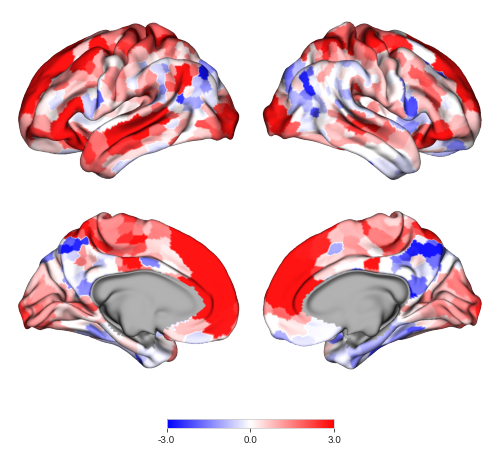

In [64]:
data = dfp.loc['b2e'].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
figure = p.build()
figure.savefig('b2e.png', dpi=300)

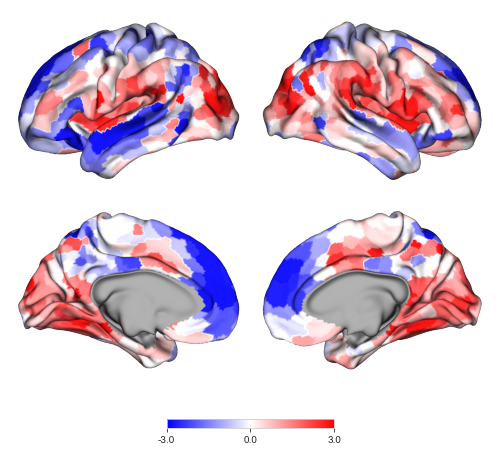

In [65]:
data = dfp.loc['e2l'].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
figure = p.build()
figure.savefig('e2l.png', dpi=300)

### spider plot

In [66]:
# average over networks
data = dfp.groupby(level=[0,2])['T'].mean()
data

contrast  7net       
b2e       Cont           0.617898
          Default        1.609571
          DorsAttn       0.836526
          Limbic        -0.152700
          SalVentAttn    0.220347
          SomMot         1.415252
          Striatum      -0.417750
          Vis            0.897312
e2l       Cont           0.491055
          Default       -0.663127
          DorsAttn      -0.463866
          Limbic         0.229587
          SalVentAttn    1.435452
          SomMot         0.444773
          Striatum       1.251973
          Vis            1.590255
Name: T, dtype: float64

In [86]:
import plotly.graph_objects as go

nets = data.index.droplevel(0).tolist()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=data.loc['b2e'],
    theta=nets,
    fill='toself',
    name='Baseline to Early'
))
fig.add_trace(go.Scatterpolar(
    r=data.loc['e2l'],
    theta=nets,
    fill='toself',
    name='Early to Late'
))
fig.add_trace(go.Barpolar(
    r=[0.1]*8,
    theta=nets,
    name='zero',
    marker_color='black',
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-3,3]  # -4, 4
        )),
    showlegend=True,
)

fig.show()
fig.write_image("spider-pairwise.svg")

In [ ]:
# todo abs(t) for spider plot, but blue and red for negative and positive -- two plots

In [92]:
data1 = data.loc['b2e']

In [101]:
data1.apply(lambda x: x if x>0 else None)

7net
Cont           0.617898
Default        1.609571
DorsAttn       0.836526
Limbic              NaN
SalVentAttn    0.220347
SomMot         1.415252
Striatum            NaN
Vis            0.897312
Name: T, dtype: float64

In [102]:
data1.apply(lambda x: -x if x<0 else None)

7net
Cont               NaN
Default            NaN
DorsAttn           NaN
Limbic         0.15270
SalVentAttn        NaN
SomMot             NaN
Striatum       0.41775
Vis                NaN
Name: T, dtype: float64

In [111]:
nets = data.index.droplevel(0).tolist()
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=data1.apply(lambda x: x if x>0 else None),
    theta=nets,
    fill='none',
    name='Baseline to Early Positive'
))
fig.add_trace(go.Scatterpolar(
    r=data1.apply(lambda x: -x if x<0 else None),
    theta=nets,
    fill='none',
    name='Baseline to Early Negative'
))
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0,3]
        )),
    showlegend=True,
)

fig.show()
# fig.write_image("spider-pairwise.svg")

### masked with FDR pvalue

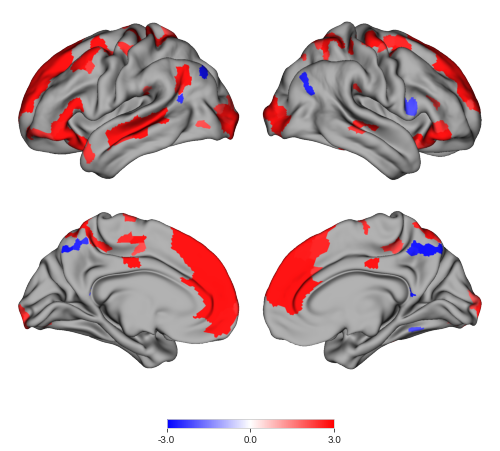

In [16]:
data = dfp.loc['b2e']
data = data.apply(lambda r: r['T'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

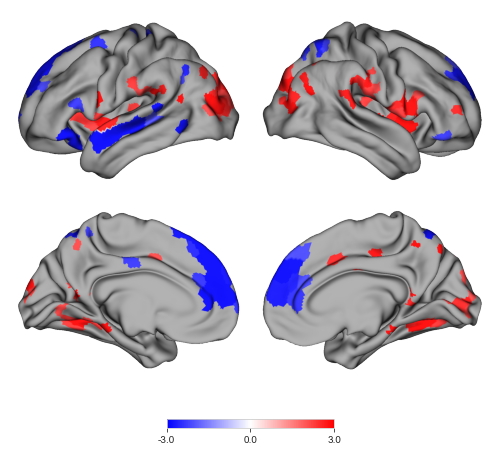

In [17]:
data = dfp.loc['e2l']
data = data.apply(lambda r: r['T'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

## outlined

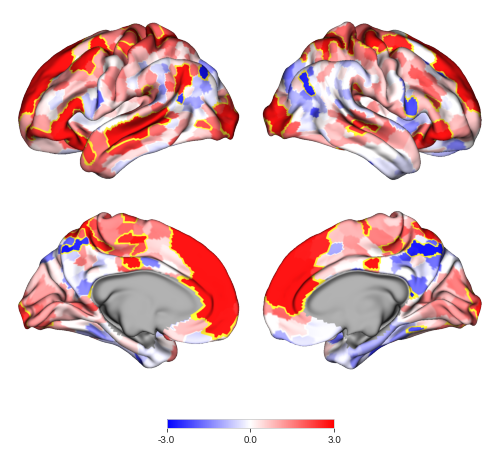

In [18]:
data = dfp.loc['b2e'].reset_index()
data1 = data['T']
data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700),
         # views=['dorsal']
         )
p.add_layer(data1, cbar=True, cmap='bwr', color_range=(-3, 3))

data2 = data.apply(lambda r: True if r['p-corr'] < 0.05 else False, axis=1).values
data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
p.add_layer(data2, cbar=False, as_outline=True)

figure = p.build()
figure.savefig('b2e outlined.png', dpi=300)

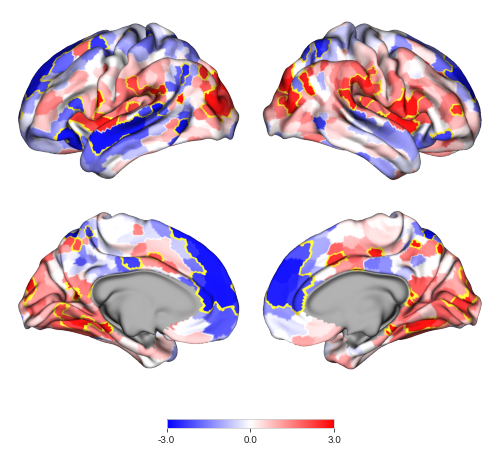

In [19]:
data = dfp.loc['e2l'].reset_index()
data1 = data['T']
data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data1, cbar=True, cmap='bwr', color_range=(-3, 3))

data2 = data.apply(lambda r: True if r['p-corr'] < 0.05 else False, axis=1).values
data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
p.add_layer(data2, cbar=False, as_outline=True)

figure = p.build()
figure.savefig('e2l outlined.png', dpi=300)

# anova
repeated measures

In [ ]:
df.head()

In [7]:
# dfa = df.groupby(['region', '7net', '17net']).apply(pg.rm_anova, dv='ecc',
#                                       within='epoch', subject='subject')

In [8]:
# _, dfa['p-corr'] = pg.multicomp(dfa['p-unc'], method='fdr_bh')

In [ ]:
# save and read dfa
# dfa.to_csv('data/dfa.csv')
dfa = pd.read_csv('data/dfa.csv', index_col=[0,1,2])

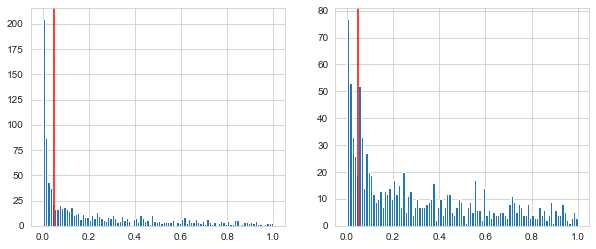

In [23]:
_, ax = plt.subplots(ncols=2, figsize=(10,4))
dfa['p-unc'].hist(bins=100, ax=ax[0]) # uncorrected p value
ax[0].axvline(x=.05, color='red') # type-I error
dfa['p-corr'].hist(bins=100, ax=ax[1]) # corrected p value
ax[1].axvline(x=.05, color='red') # type-I error
plt.show()

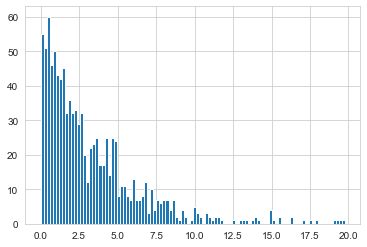

In [24]:
dfa['F'].hist(bins=100)
plt.show()

In [25]:
# views in ['medial', 'lateral', 'ventral', 'dorsal', 'anterior', 'posterior']

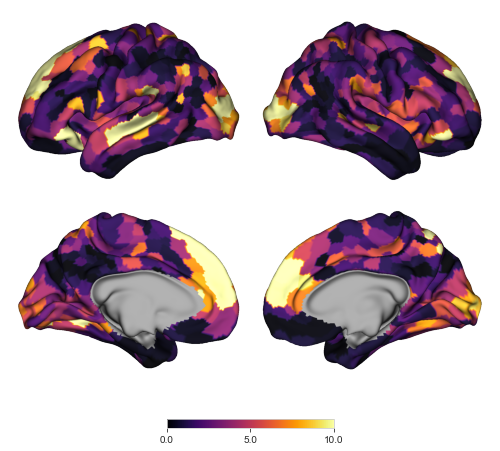

In [74]:
data = dfa.loc[region_names]['F'].values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), views=['lateral', 'medial'])
p.add_layer(data, cbar=True, cmap='inferno', color_range=(0, 10))

figure = p.build()
figure.savefig('anova.png', dpi=300)

masked with p value corrected

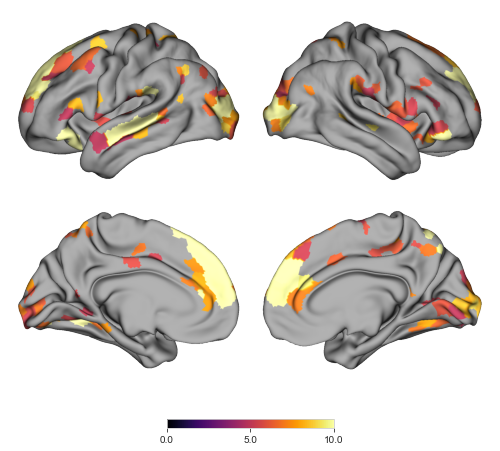

In [78]:
data = dfa.loc[region_names]
data1 = data.apply(lambda r: r['F'] if r['p-corr'] < 0.05 else None, axis=1).values
data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data1, cbar=True, cmap='inferno', color_range=(0, 10))
# data2 = data['p-corr'].apply(lambda r: True if r < 0.05 else False).values
# data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
# p.add_layer(data2, cbar=False, as_outline=True)
figure = p.build()
figure.savefig('anova cut.png', dpi=300)

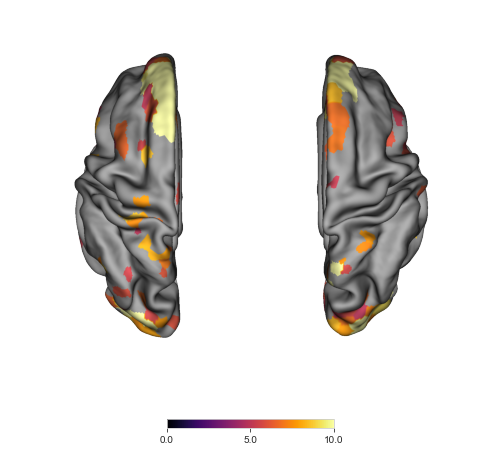

In [79]:
# same for views='Dorsal'
data = dfa.loc[region_names]
data1 = data.apply(lambda r: r['F'] if r['p-corr'] < 0.05 else None, axis=1).values
data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), views=['dorsal'])
p.add_layer(data1, cbar=True, cmap='inferno', color_range=(0, 10))
# data2 = data['p-corr'].apply(lambda r: True if r < 0.05 else False).values
# data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
# p.add_layer(data2, cbar=False, as_outline=True)
figure = p.build()
figure.savefig('anova cut dorsal.png', dpi=300)

## outlined

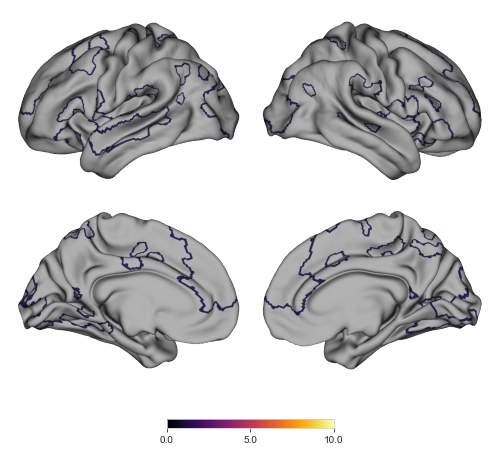

In [28]:
data = dfa.loc[region_names]
data1 = data['F'].values
data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
plot = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
# plot.add_layer(data1, cbar=True, cmap='inferno', color_range=(0, 10))


data2 = data.apply(lambda r: True if r['p-corr'] < 0.05 else False, axis=1).values
data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
plot.add_layer(data2, cbar=False, as_outline=True)
# how to change outline color?


figure = p.build()
# figure.savefig('anova outlined.png', dpi=300)

find the region in `DorsAttnA` that is significant

In [59]:
# select rows by specifying 2nd level index == 'DorsAttnA'
# and p-corr < 0.05
dfa.xs('DorsAttnA', level='17net').loc[lambda df: df['p-corr'] < 0.05]

,,,Source,ddof1,ddof2,F,p-unc,ng2,eps,p-GG-corr,sphericity,W-spher,p-spher,p-corr
region,7net,,,,,,,,,,,,,
7Networks_LH_DorsAttn_Post_14,DorsAttn,0,epoch,2,70,5.519325,0.005946,0.116211,0.933532,NaN,NaN,NaN,NaN,0.034735
7Networks_LH_DorsAttn_Post_41,DorsAttn,0,epoch,2,70,6.057937,0.003745,0.109494,0.827065,0.006541,False,0.790906,0.018540,0.025494
7Networks_LH_Vis_61,Vis,0,epoch,2,70,7.151766,0.001492,0.138284,0.960346,NaN,NaN,NaN,NaN,0.014237
7Networks_RH_DorsAttn_Post_45,DorsAttn,0,epoch,2,70,5.607629,0.005510,0.105272,0.988328,NaN,NaN,NaN,NaN,0.032798
7Networks_RH_DorsAttn_Post_46,DorsAttn,0,epoch,2,70,11.063827,0.000067,0.177625,0.852828,0.000182,False,0.827430,0.039942,0.002124


# plot on subcortex
Nothing significant in ANOVA or t-tests from baseline to early.

Left Accumbens is very significant from early to late.

In [29]:
dfp.loc['e2l'][-14:]

,,,T,p-unc,p-corr
region,7net,17net,,,
Left Thalamus,Striatum,StriatumLeft,1.627245,0.112656,0.277814
Left Caudate,Striatum,StriatumLeft,0.727243,0.471914,0.757778
Left Putamen,Striatum,StriatumLeft,1.699253,0.098145,0.294434
Left Pallidum,Striatum,StriatumLeft,1.158822,0.254374,0.506893
Left Hippocampus,Striatum,StriatumLeft,1.466847,0.151346,0.227020
Left Amygdala,Striatum,StriatumLeft,-0.091539,0.927586,0.927586
Left Accumbens,Striatum,StriatumLeft,2.284456,0.028521,0.085563
Right Thalamus,Striatum,StriatumRight,1.851092,0.072610,0.171228
Right Caudate,Striatum,StriatumRight,1.976656,0.056002,0.168006


setup subcortex plotting

In [30]:
subcortex_order = ['Left Accumbens',
                     'Left Amygdala',
                     'Left Caudate',
                     'Left Hippocampus',
                     'Left Pallidum',
                     'Left Putamen',
                     'Left Thalamus',
                     # 'Left Ventricles',
                     'Right Accumbens',
                     'Right Amygdala',
                     'Right Caudate',
                     'Right Hippocampus',
                     'Right Pallidum',
                     'Right Putamen',
                     'Right Thalamus',
                     # 'Right Ventricles',
                   ]

# to reorder data regarding function input
# array_name = data.loc[subcortex_order]
# two values removed, ventricles must set False
# to finish the cell, you need to close the window that shows plot
# to save it, pass both screenshot and filename

## t-test

In [45]:
from enigmatoolbox.plotting import plot_subcortical

plot_subcortical(dfp.loc['b2e'].loc[subcortex_order]['T'], ventricles=False,
                 size=(800, 400), cmap='bwr', color_bar=True, color_range=(-3,3),
                 screenshot=True, filename='b2e subc.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/b2e subc.png'

In [46]:
plot_subcortical(dfp.loc['e2l'].loc[subcortex_order]['T'], ventricles=False,
                 size=(800, 400), cmap='bwr', color_bar=True, color_range=(-3,3),
                 screenshot=True, filename='e2l subc.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/e2l subc.png'

In [51]:
dfp[-14*2:]

,,,,T,p-unc,p-corr
contrast,region,7net,17net,,,
b2e,Left Thalamus,Striatum,StriatumLeft,-0.470042,0.641240,0.641240
e2l,Left Thalamus,Striatum,StriatumLeft,1.627245,0.112656,0.277814
b2e,Left Caudate,Striatum,StriatumLeft,-0.407948,0.685797,0.757778
e2l,Left Caudate,Striatum,StriatumLeft,0.727243,0.471914,0.757778
b2e,Left Putamen,Striatum,StriatumLeft,-0.654391,0.517137,0.517137
e2l,Left Putamen,Striatum,StriatumLeft,1.699253,0.098145,0.294434
b2e,Left Pallidum,Striatum,StriatumLeft,-0.796305,0.431223,0.506893
e2l,Left Pallidum,Striatum,StriatumLeft,1.158822,0.254374,0.506893
b2e,Left Hippocampus,Striatum,StriatumLeft,-0.417303,0.679006,0.679006


## ANOVA

In [36]:
dfa[-14:]

,,,,Source,ddof1,ddof2,F,p-unc,ng2,eps,p-GG-corr,sphericity,W-spher,p-spher,p-corr
region,7net,17net,,,,,,,,,,,,,
Left Accumbens,Striatum,StriatumLeft,0,epoch,2,70,1.489483,0.232548,0.027270,0.819872,0.234564,False,0.780297,0.014737,0.368301
Left Amygdala,Striatum,StriatumLeft,0,epoch,2,70,0.143088,0.866930,0.003358,0.757131,0.808138,False,0.679224,0.001394,0.902104
Left Caudate,Striatum,StriatumLeft,0,epoch,2,70,0.258191,0.773180,0.004999,0.986139,NaN,NaN,NaN,NaN,0.832402
Left Hippocampus,Striatum,StriatumLeft,0,epoch,2,70,1.518010,0.226273,0.030632,0.844541,0.228633,False,0.815925,0.031482,0.361751
Left Pallidum,Striatum,StriatumLeft,0,epoch,2,70,0.862185,0.426673,0.016064,0.812561,0.407225,False,0.769323,0.011584,0.552943
Left Putamen,Striatum,StriatumLeft,0,epoch,2,70,1.561793,0.216980,0.031490,0.862247,NaN,NaN,NaN,NaN,0.351334
Left Thalamus,Striatum,StriatumLeft,0,epoch,2,70,1.650773,0.199284,0.029290,0.976151,NaN,NaN,NaN,NaN,0.330615
Right Accumbens,Striatum,StriatumRight,0,epoch,2,70,0.668634,0.515650,0.013495,0.915080,NaN,NaN,NaN,NaN,0.627964
Right Amygdala,Striatum,StriatumRight,0,epoch,2,70,0.214385,0.807566,0.005006,0.772746,0.750114,False,0.705913,0.002684,0.857562


In [77]:
plot_subcortical(dfa.loc[subcortex_order]['F'], ventricles=False,
                 size=(800, 400),
                 cmap='inferno',
                 color_bar=True,
                 color_range=(0,3),
                 screenshot=True, filename='anova subc.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/anova subc.png'

In [41]:
data = dfa.loc[subcortex_order]
data1 = data.apply(lambda r: r['F'] if r['p-corr'] < 0.05 else None, axis=1).values
plot_subcortical(data1, ventricles=False,
                 size=(800, 400),
                 cmap='inferno',
                 color_bar=True,
                 color_range=(0,3),
                 # screenshot=True, filename='anova subc cut.png'
                 )

no region is significant in ANOVA, so the subcortical plot is empty

## fdr
no significant regions even after correction in striatum

In [ ]:
l = dfp.loc['e2l'][-14:]['p-unc'].values
l

In [ ]:
reject, l = pg.multicomp(l, method='fdr_bh')
l

# appendix
how to interpret t-tests results

In [ ]:
d = df.set_index(['region','epoch',  'subject'])[['ecc']]
d = d.loc['7Networks_LH_Cont_Cing_1']
d

In [ ]:
import seaborn

seaborn.displot(d.iloc[36:], hue='epoch', x='ecc', kind='kde')

In [ ]:
d=d.unstack(0)['ecc']
d

In [ ]:
pg.ttest(d['late'],d['early'], paired=True)

In [ ]:
pg.ttest(d['late']-d['early'], 0)